In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras 

import os
from distutils.dir_util import copy_tree, remove_tree
from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, MaxPool2D
import datetime



print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.5.0


In [3]:
base_dir = 'C:/Users/GHANAM/Desktop/MRI DATASET0.2/Alzheimer_s Dataset/'
root_dir = 'C:/Users/GHANAM/Desktop/MRI DATASET0.2/The Generated data/'
test_dir = base_dir + "test/"
train_dir = base_dir + "train/" 
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
WORK_DIR = 'C:/Users/GHANAM/Desktop/MRI DATASET0.2/The Generated data/dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


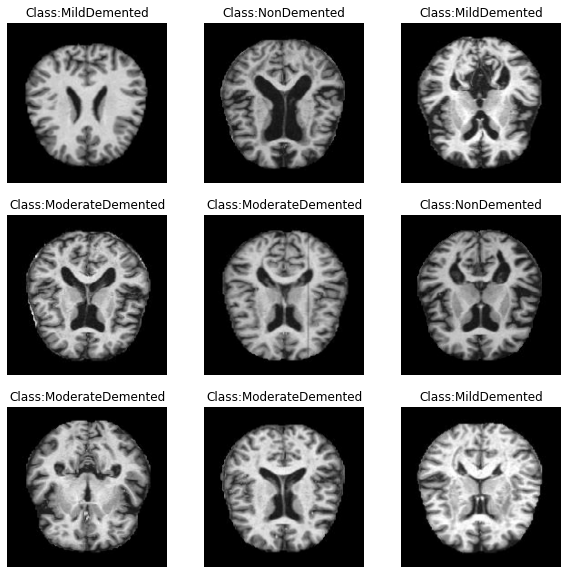

In [6]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [7]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [8]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


C:\Users\GHANAM\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [9]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [10]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [11]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [56]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model_1")

    return model

In [13]:
# #Defining a custom callback function to stop training our model when accuracy goes above 99%

# class MyCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if logs.get('val_acc') > 0.99:
#             print("\nReached accuracy threshold! Terminating training.")
#             self.model.stop_training = True
            
# my_callback = MyCallback()

# #EarlyStopping callback to make sure model is always learning
# early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [14]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [15]:
strategy = tf.distribute.get_strategy()

In [16]:
# # Clear any logs from previous runs
# rm -rf ./logs/

In [17]:
with strategy.scope():
    model = construct_model()

    METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
               tf.keras.metrics.AUC(name='auc'),
               tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),

               tfa.metrics.F1Score(num_classes=4)]

    #CALLBACKS = [my_callback]

    model.compile(optimizer='adam',
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=METRICS)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 176, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 44, 44, 32)        14016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        55680     
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)       0 

In [20]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_cnn_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [21]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler,tensorboard_callback], epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - ETA: 0s - loss: 1.4571 - acc: 0.2896 - auc: 0.5533 - precision: 0.3491 - recall: 0.0521 - f1_score: 0.2864

C:\Users\GHANAM\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


256/256 [==============================] - 443s 2s/step - loss: 1.4571 - acc: 0.2896 - auc: 0.5533 - precision: 0.3491 - recall: 0.0521 - f1_score: 0.2864 - val_loss: 1.4242 - val_acc: 0.2695 - val_auc: 0.5225 - val_precision: 0.3333 - val_recall: 0.0039 - val_f1_score: 0.2187
Epoch 2/100
256/256 [==============================] - 442s 2s/step - loss: 1.2331 - acc: 0.4200 - auc: 0.6986 - precision: 0.5971 - recall: 0.1407 - f1_score: 0.4028 - val_loss: 32.4893 - val_acc: 0.2646 - val_auc: 0.4939 - val_precision: 0.2646 - val_recall: 0.2646 - val_f1_score: 0.1413
Epoch 3/100
256/256 [==============================] - 470s 2s/step - loss: 0.9670 - acc: 0.5680 - auc: 0.8307 - precision: 0.6876 - recall: 0.3687 - f1_score: 0.5487 - val_loss: 0.9184 - val_acc: 0.5728 - val_auc: 0.8472 - val_precision: 0.7305 - val_recall: 0.3560 - val_f1_score: 0.5494
Epoch 4/100
256/256 [==============================] - 469s 2s/step - loss: 0.8566 - acc: 0.6084 - auc: 0.8643 - precision: 0.7203 - recall: 

In [22]:
%tensorboard --logdir logs/fit

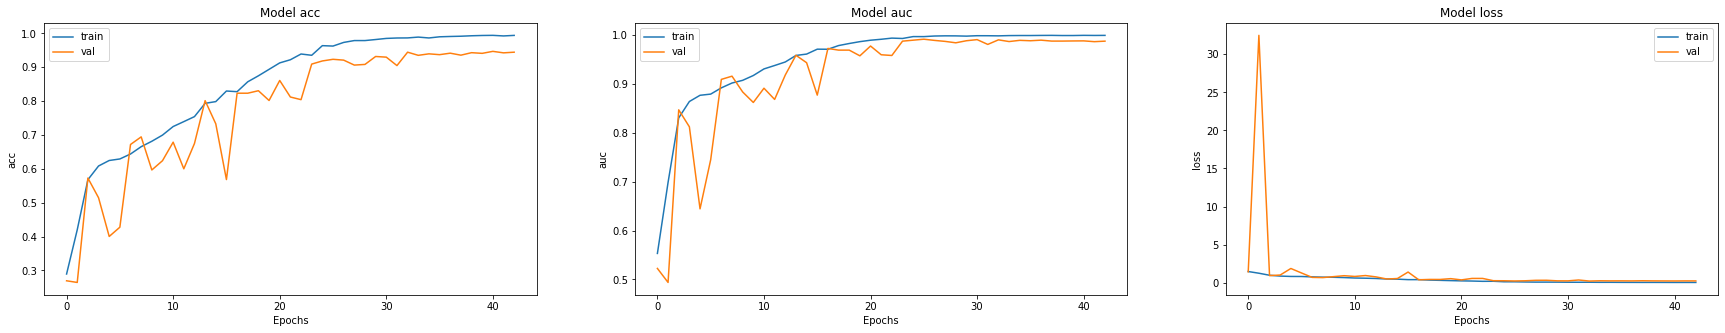

In [23]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

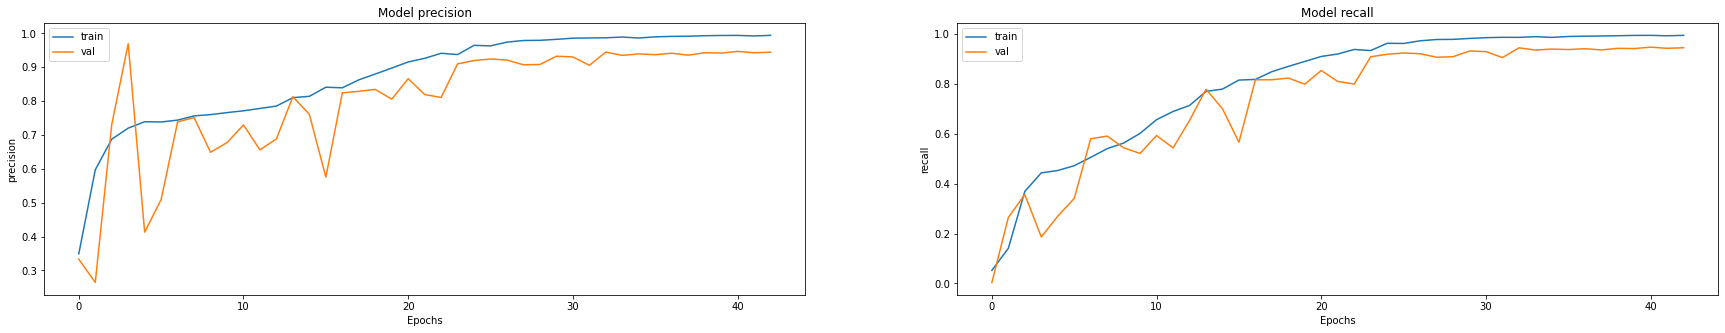

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["precision", "recall"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [25]:
test_scores = model.evaluate(test_data, test_labels)

80/80 [==============================] - 34s 421ms/step - loss: 0.2166 - acc: 0.9406 - auc: 0.9892 - precision: 0.9406 - recall: 0.9406 - f1_score: 0.9412


In [26]:
pred_labels = model.predict(test_data)

In [27]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.99      0.96      0.98       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.92      0.87      0.90       662
ModerateDemented       0.86      0.93      0.89       624

       micro avg       0.94      0.94      0.94      2560
       macro avg       0.94      0.94      0.94      2560
    weighted avg       0.94      0.94      0.94      2560
     samples avg       0.94      0.94      0.94      2560



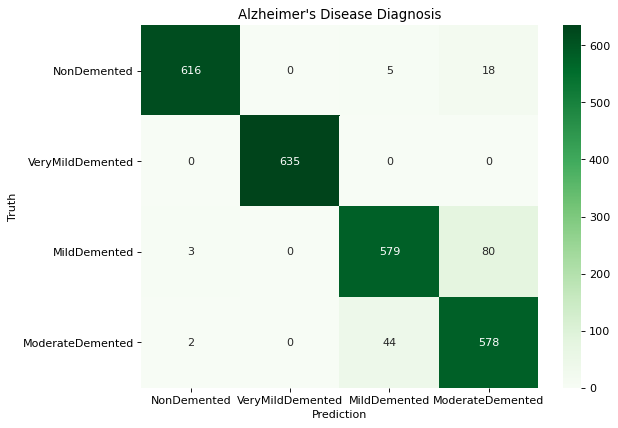

In [28]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [29]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 94.12 %
Matthew's Correlation Coefficient: 92.12 %


In [30]:
model_dir = work_dir + "alzheimer_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [ ]:
########################### InceptionV3 ###############################

In [58]:
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [59]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [60]:
for layer in inception_model.layers:
    layer.trainable=False

In [61]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [62]:
with strategy.scope():
    

    METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
               tf.keras.metrics.AUC(name='auc'),
               tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),

               tfa.metrics.F1Score(num_classes=4)]

    

    custom_inception_model.compile(optimizer='adam',
                  loss=tf.losses.CategoricalCrossentropy(),
                  metrics=METRICS)
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
dropout_25 (Dropout)         (None, 4, 4, 2048)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_221 (Bat (None, 2048)              8192      
_________________________________________________________________
dense_21 (Dense)             (None, 512)               1049088   
_________________________________________________________________
batch_normalization_222 (Bat (None, 512)       

In [37]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_inception_cnn_model",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [64]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
           tfa.metrics.F1Score(num_classes=4)]

#CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='adam',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)



In [65]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler,tensorboard_callback], epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - ETA: 0s - loss: 1.1186 - acc: 0.4941 - auc: 0.7679 - precision: 0.6261 - recall: 0.2839 - f1_score: 0.4850

C:\Users\GHANAM\anaconda3\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


256/256 [==============================] - 290s 1s/step - loss: 1.1186 - acc: 0.4941 - auc: 0.7679 - precision: 0.6261 - recall: 0.2839 - f1_score: 0.4850 - val_loss: 0.7516 - val_acc: 0.6411 - val_auc: 0.8929 - val_precision: 0.7587 - val_recall: 0.4883 - val_f1_score: 0.6288
Epoch 2/100
256/256 [==============================] - 281s 1s/step - loss: 0.8216 - acc: 0.6207 - auc: 0.8744 - precision: 0.7415 - recall: 0.4595 - f1_score: 0.6086 - val_loss: 0.6509 - val_acc: 0.6699 - val_auc: 0.9174 - val_precision: 0.7569 - val_recall: 0.5762 - val_f1_score: 0.6083
Epoch 3/100
256/256 [==============================] - 292s 1s/step - loss: 0.7470 - acc: 0.6559 - auc: 0.8972 - precision: 0.7472 - recall: 0.5258 - f1_score: 0.6483 - val_loss: 0.6405 - val_acc: 0.6821 - val_auc: 0.9209 - val_precision: 0.7619 - val_recall: 0.5923 - val_f1_score: 0.6253
Epoch 4/100
256/256 [==============================] - 298s 1s/step - loss: 0.7060 - acc: 0.6837 - auc: 0.9093 - precision: 0.7670 - recall: 0

In [66]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 14536), started 17:19:12 ago. (Use '!kill 14536' to kill it.)

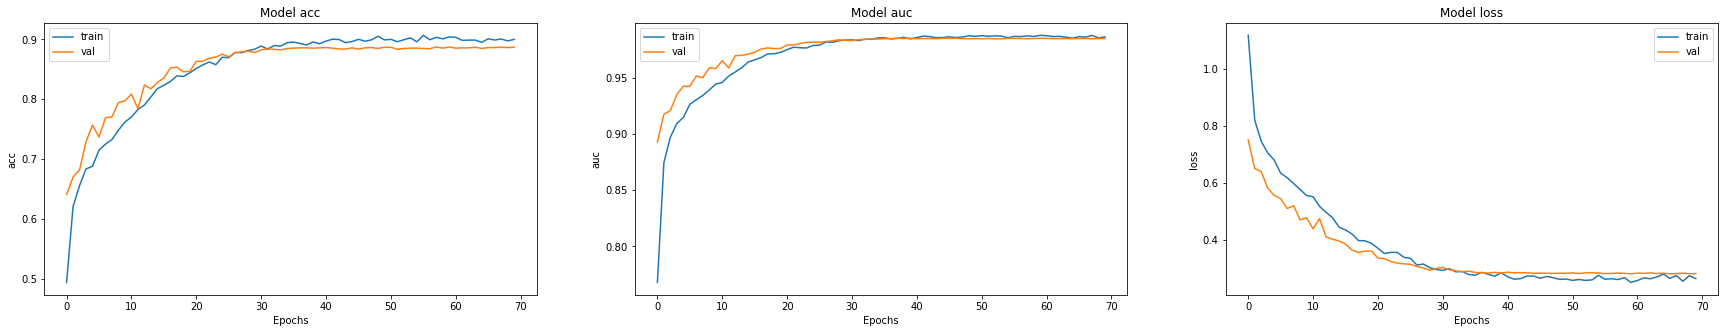

In [67]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

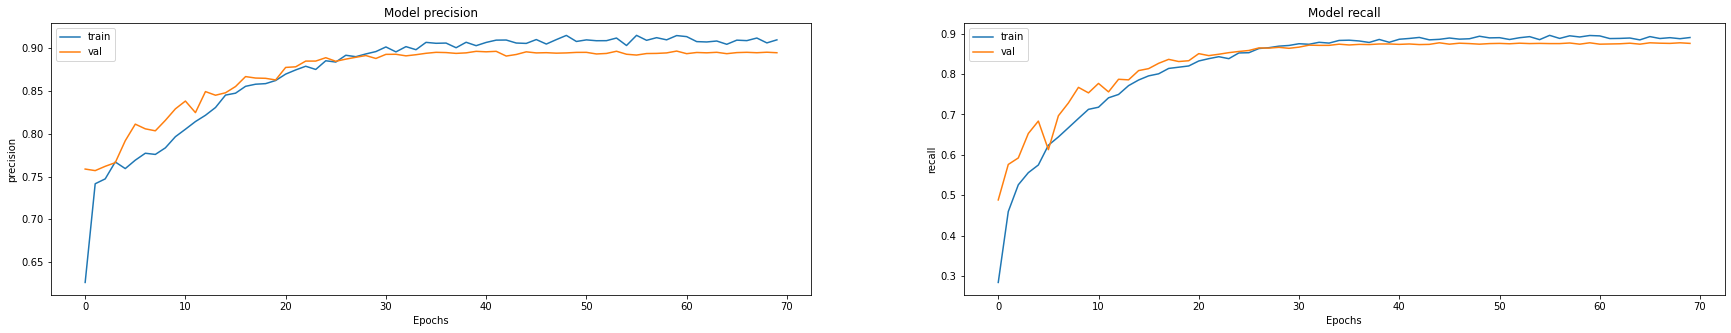

In [68]:
fig, ax = plt.subplots(1, 2, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["precision", "recall"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [69]:
test_scores = custom_inception_model.evaluate(test_data, test_labels)

80/80 [==============================] - 74s 923ms/step - loss: 0.3285 - acc: 0.8676 - auc: 0.9806 - precision: 0.8796 - recall: 0.8586 - f1_score: 0.8672


In [70]:
pred_labels = custom_inception_model.predict(test_data)

In [71]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.88      0.93      0.91       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.83      0.76      0.79       662
ModerateDemented       0.76      0.78      0.77       624

       micro avg       0.87      0.87      0.87      2560
       macro avg       0.87      0.87      0.87      2560
    weighted avg       0.87      0.87      0.87      2560
     samples avg       0.87      0.87      0.87      2560



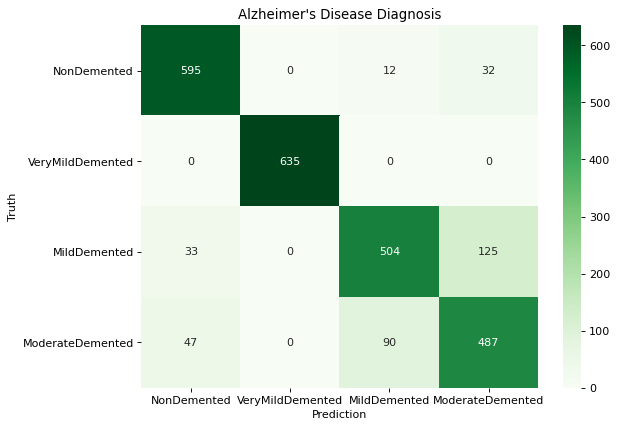

In [72]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [73]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 86.82 %
Matthew's Correlation Coefficient: 82.39 %


In [74]:
model_dir = work_dir + "alzheimer_inception_cnn_model"
model.save(model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_cnn_model',
 'alzheimer_inception_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']